In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
from datetime import datetime
import matplotlib.pyplot as plt
import dataset_fctns, plotting
import copy

In [2]:
def phase_dependent_response(driver_values, t_dev, responses, thresholds):
    #Thresholds are the thresholds in development time where the different growth phases change
    #Responses are the response functions, index starting at 'before the first threshold'
    #driver values are the inputs to the response function
    #t_dev is the (cts) development time
    phase = np.digitize(t_dev, thresholds)
    response = np.zeros(driver_values.shape)
    for phase_index in range(len(responses)):
        response += (phase == phase_index)*responses[phase_index](driver_values) #First brackets indicates if we are at the right phase, second takes the response function for each phase
    return response

In [3]:
def get_nearest_elements(x, y, ds):
    #Interpolates the input array onto the (non-gridded e.g. phenology station) coordinates x and y.
    #Note hyras is not stored on the full grid, but on some kind of subset. Not quite sure how this works. Just got to hope the stations are in a hyras gridpoint.
    X_for_interp = xr.DataArray(x, dims="modelpoint")
    Y_for_interp = xr.DataArray(y, dims="modelpoint")
    return ds.interp(x=X_for_interp, y=Y_for_interp)#, kwargs={"fill_value": None})

In [4]:
def latlon_to_projection(x_coords, y_coords):
    proj_epsg = ccrs.epsg(3034)
    proj_latlon = ccrs.PlateCarree()
    points_epsg = proj_epsg.transform_points(proj_latlon, x_coords, y_coords)
    x_epsg = points_epsg[:, 0]
    y_epsg = points_epsg[:, 1]
    return x_epsg, y_epsg

In [22]:
def make_input_array(emergence_times, station_ids, reference_years, x_coords, y_coords, ds_driver):
    #Put in transforming to the right coords here x
    print('project to new coords')
    
    x_epsg, y_epsg = latlon_to_projection(x_coords, y_coords)
    print('interpolate driver to station locations')
    ds_driver_interp = get_nearest_elements(x_epsg, y_epsg, ds_driver)
    ds_driver_interp['emergence_dates'] = (("modelpoint"), emergence_times)
    ds_driver_interp['Stations_id'] = (("modelpoint"), station_ids)
    ds_driver_interp['Referenzjahr'] = (("modelpoint"), reference_years)
    ds_driver_interp = ds_driver_interp.assign_coords(modelpoint=np.arange(ds_driver_interp.sizes['modelpoint']))
    return ds_driver_interp#.dropna(dim='modelpoint')


In [148]:
def dev_under_response(response, ds_driver, driver_variable, maturity_t_dev):
    # Response is the rate response to driver values. Driver values are the input to this response. Maturity_t_dev is the t_dev value where we should stop running.
    # Put in the date as (day, month, year)
    t_dev = np.zeros(ds_driver[driver_variable].isel(time=0).values.shape) #Continuous development time. When this passes through some thresholds then have change in phase.
    dev_time_series = [t_dev.copy()]
    #i_day = np.datetime64(f'{emergence_date[2]}-{str(emergence_date[1]).zfill(2)}-{str(emergence_date[0]).zfill(2)}')
    i_day = ds_driver['emergence_dates'].values.copy()
    i_day = i_day + np.timedelta64(12, 'h') #so that times are at midday rather than midnight
    time_indexer = xr.DataArray(i_day, dims=["modelpoint"])
    ds_driver.sel(time=time_indexer, method='nearest')
    day_count = 0
    while day_count < 365:#while np.sum(t_dev < maturity_t_dev) > 0.05*len(ds_driver['modelpoint']):
        print(day_count)
        #driver_values = ds_driver.sel(time=np.datetime_as_string(i_day, unit='D')).squeeze().values
        driver_values = ds_driver.sel(time=time_indexer, method='nearest')[driver_variable].values
        #print(t_dev[t_dev<maturity_t_dev])
        print(len(driver_values[t_dev<maturity_t_dev]))
        t_dev += response(driver_values, t_dev) #Rate of change of development stage
        dev_time_series.append(t_dev.copy())
        i_day += np.timedelta64(1,'D')
        day_count += 1
    return np.stack(dev_time_series)

In [7]:
def get_phase_dates(dev_time_series, thresholds):
    phase_dates_array = np.zeros((len(thresholds), dev_time_series.shape[1]))
    for obs_index in range(dev_time_series.shape[1]):
        phase_dates_array[:, obs_index] = np.digitize(thresholds, dev_time_series[:, obs_index]) #Note that the thresholds are NOT the bins for numpy digitize!
    return phase_dates_array

In [67]:
def get_modelled_dataset(ds_driver, phase_times, phase_list = []):
    reference_years = np.int64(ds_driver['Referenzjahr'].values)
    Stations_id = np.int64(ds_driver['Stations_id'].values)
    if len(phase_list) == 0:
        computed_phases = [f'modelled time emergence to phase {i + 1}' for i in range(phase_times.shape[0])]
    else:
        computed_phases = [f'modelled time emergence to {phase}' for phase in phase_list]
    data_comparison = {'Stations_id': Stations_id,
                       'Referenzjahr': reference_years,
                       }
    ds_comparison = pd.DataFrame(data_comparison)
    for phase_index, phase in enumerate(computed_phases):
        ds_comparison[phase] = phase_times[phase_index, :]
    ds_comparison.set_index(['Stations_id', 'Referenzjahr'], inplace=True)
    return ds_comparison

# NOTE 
Issue with duplicates was just from quality checking

In [121]:
def get_observed_dataset(ds_verification, phase_list):
    observed_to_first_stage = dataset_fctns.time_stage_to_stage(phen_data_maize, 'beginning of emergence', phase_list[0]).dropna()
    ds_observed = pd.DataFrame({f'observed time emergence to {phase_list[0]}': observed_to_first_stage})
    for phase in phase_list[1:]:
        ds_observed[f'observed time emergence to {phase}'] = dataset_fctns.time_stage_to_stage(ds_verification, 'beginning of emergence', phase).dropna()
    return ds_observed

In [162]:
phen_data_maize = phen_data_maize.where(phen_data_maize['Qualitaetsniveau'] == 10).dropna()
ds_observed = get_observed_dataset(phen_data_maize, ['beginning of flowering', 'yellow ripeness'])

In [163]:
model_times = get_modelled_dataset(ds_driver, phase_times, phase_list=['beginning of flowering', 'yellow ripeness'])
full_dataset = pd.concat([model_times, ds_observed], axis = 1)

In [23]:
## READ IN DATA ##
ds_mean = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\tas_hyras_5_1951_2020_v5-0_de.nc')
phen_data_maize = dataset_fctns.read_phen_dataset("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\PH_Jahresmelder_Landwirtschaft_Kulturpflanze_Mais_1936_2023_hist.txt", drop_list = ['Unnamed: 9'])
phase_names = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phase.txt", encoding = "latin1", engine='python', sep = r';\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;')
station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')
station_data = station_data.drop('Unnamed: 12', axis = 1)
## READ IN DATA FOR PHASE NAMES IN ORDER ##
#print(phase_names['Phase_ID'])
phen_data_maize = dataset_fctns.add_locations(phen_data_maize, station_data)
phen_data_maize = dataset_fctns.phase_order_name(phen_data_maize, phase_names, [10, 12, 67, 65, 5, 6, 19, 20, 21, 24, ])
phen_data_maize = dataset_fctns.order_phen_dataset(phen_data_maize)
#phen_data_wheat = dataset_fctns.add_locations(phen_data_wheat, station_data)
#phen_data_wheat = dataset_fctns.phase_order_name(phen_data_wheat, phase_names, [10, 12, 15, 18, 19, 21, 22, 23, 24, ])
#phen_data_wheat = dataset_fctns.order_phen_dataset(phen_data_wheat)
just_emergence_phen_data = phen_data_maize.where(phen_data_maize['Name of phase'] == 'beginning of emergence').dropna()
just_emergence_phen_data = just_emergence_phen_data.where(just_emergence_phen_data['Eintrittsdatum'] > np.datetime64('2005-01-01')).dropna()
emergences = just_emergence_phen_data['Eintrittsdatum'].values
station_ids = just_emergence_phen_data['Stations_id'].values
reference_years = just_emergence_phen_data['Referenzjahr'].values
x_coords = just_emergence_phen_data['lon'].values
y_coords = just_emergence_phen_data['lat'].values
ds_driver = make_input_array(emergences, station_ids, reference_years, x_coords, y_coords, ds_mean)

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_6496\585534896.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


project to new coords
interpolate driver to station locations


In [2]:
def Wang_Engel_Temp_response(T, T_min, T_opt, T_max, beta = 1):
    alpha = np.log(2)/np.log( (T_max - T_min)/(T_opt - T_min) )
    f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta
    f_T = np.nan_to_num(f_T)
    return f_T*(T >= T_min)*(T<= T_max)

In [15]:
def Trapezoid_Temp_response(T, T_min, T_opt1, T_opt2, T_max):
    pre_opt = (T>=T_min)*(T<=T_opt1)
    opt = (T>=T_opt1)*(T<=T_opt2)
    post_opt = (T>=T_opt2)*(T<=T_max)
    return pre_opt*(T - T_min)/(T_opt1 - T_min) + opt + post_opt*(T_max - T)/(T_max - T_opt2)

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_10828\2397755492.py:3: RuntimeWarning: invalid value encountered in power
  f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta


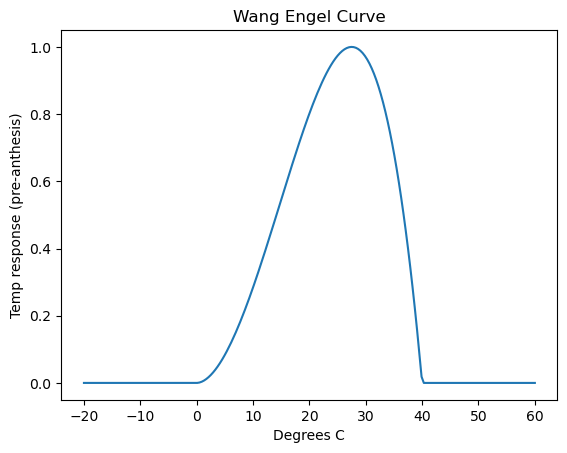

In [4]:
x = np.linspace(-20, 60, 200)
y = Wang_Engel_Temp_response(x, 0, 27.5, 40)
plt.plot(x, y)
plt.title('Wang Engel Curve')
plt.xlabel('Degrees C')
plt.ylabel('Temp response (pre-anthesis)')
plt.savefig('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\plots\\wangengel.png')

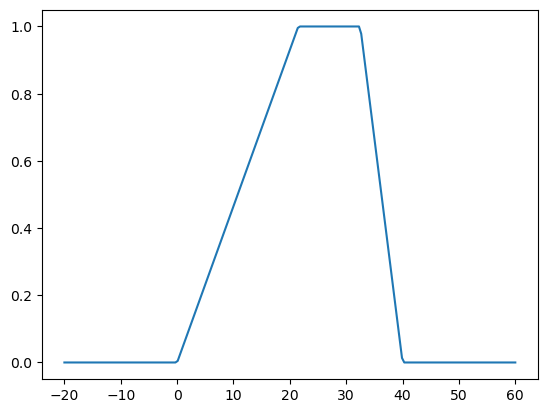

In [17]:
x = np.linspace(-20, 60, 200)
#y = Wang_Engel_Temp_response(x, 0, 27.5, 40)
y = Trapezoid_Temp_response(x, 0, 21.5, 32.5, 40)
plt.plot(x, y)

In [ ]:
resps = [lambda x: Wang_Engel_Temp_response(x, 0, 27.5, 40), lambda x: Wang_Engel_Temp_response(x, 0, 33, 44)]
thresholds = [45, 65]
ds_driver = ds_driver.dropna(dim='modelpoint')
prediction = dev_under_response(lambda x, y: phase_dependent_response(x, y, resps, thresholds), 
                                ds_driver, 'tas', thresholds[-1])
phase_times = get_phase_dates(prediction, thresholds)

Make a dataset with predicted flowering times and actual flowering times, predicted maturity times and actual maturity times. Then get RMSE. Make a clause that if a phase takes longer than 300 then 'not achieved'.

Index result dataset by 'Stations_id' and 'Referenzjahr'.
Then make a new dataset with the existing functions.

In [ ]:
## Test that indexing is working well ##
i_day = ds_driver['emergence_dates'].values.copy()
for obs_index, day in enumerate(i_day):
    print(day, ds_driver['tas'].sel(time=day, modelpoint=obs_index).values)
time_indexer = xr.DataArray(i_day, dims=["modelpoint"])
ds_driver.sel(time=time_indexer, method='nearest')